In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import kagglehub

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:00<00:00, 159MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
#import scikitplot
import seaborn as sns
from matplotlib import pyplot as plt
import PIL

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from keras.utils import np_utils

In [ ]:
# Load image dataset
data = tf.keras.utils.image_dataset_from_directory('/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train', image_size=(32, 32))

Found 100000 files belonging to 2 classes.


0.0
255.0


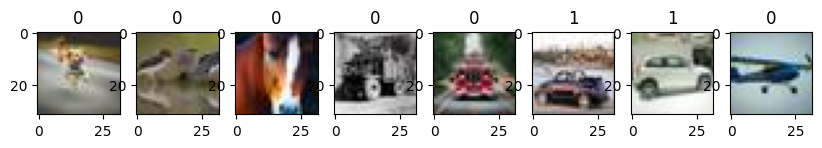

In [ ]:

# Visualize a batch of images
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

print(batch[0].min())
print(batch[0].max())

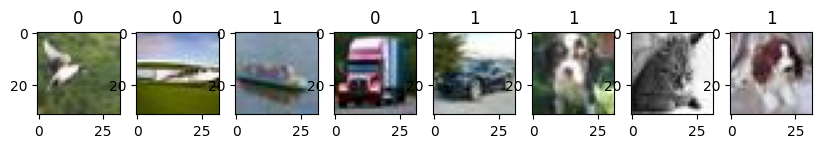

In [ ]:
# Scale pixel values to the range [0, 1]
data = data.map(lambda x, y : (x/255, y))

# Visualize a scaled batch of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# Split the dataset
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print(len(train) + len(cv) + len(test))


3125


In [ ]:
# Ai generated image recognition CNN model
ai_model = models.Sequential()

ai_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
ai_model.add(layers.BatchNormalization())
ai_model.add(layers.MaxPooling2D((2, 2)))

ai_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
ai_model.add(layers.BatchNormalization())
ai_model.add(layers.MaxPooling2D((2, 2)))

ai_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
ai_model.add(layers.BatchNormalization())

ai_model.add(layers.Flatten())
ai_model.add(layers.Dense(256, activation='relu'))
ai_model.add(layers.BatchNormalization())
ai_model.add(layers.Dropout(0.5))
ai_model.add(layers.Dense(128, activation='relu'))
ai_model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
ai_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Data Augmentation in the pipeline
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y

train_augmented = data.map(augment_data)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train
history_ai = ai_model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate
test_loss, test_accuracy = ai_model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.8387 - loss: 0.3695 - val_accuracy: 0.9073 - val_loss: 0.2326 - learning_rate: 9.5000e-04
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.9084 - loss: 0.2310 - val_accuracy: 0.9195 - val_loss: 0.2014 - learning_rate: 9.0250e-04
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.9188 - loss: 0.2045 - val_accuracy: 0.9172 - val_loss: 0.2088 - learning_rate: 8.5737e-04
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9273 - loss: 0.1870 - val_accuracy: 0.9231 - val_loss: 0.1918 - learning_rate: 8.1451e-04
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9323 - loss: 0.1710 - val_accuracy: 0.9373 - val_loss: 0.1602 - learning_rate: 7.7378e-04
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9382 - loss: 0.1605 - val_accuracy: 0.9325 - val_loss: 0.1700 - learning_rate: 7.3509e-04
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 40s

In [ ]:
from tensorflow.keras.models import load_model
from keras.models import load_model

os.makedirs('ai_model', exist_ok=True)
ai_model.save('ai_model/ai_imageclassifier.keras')

loaded_model = tf.keras.models.load_model('ai_model/ai_imageclassifier.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

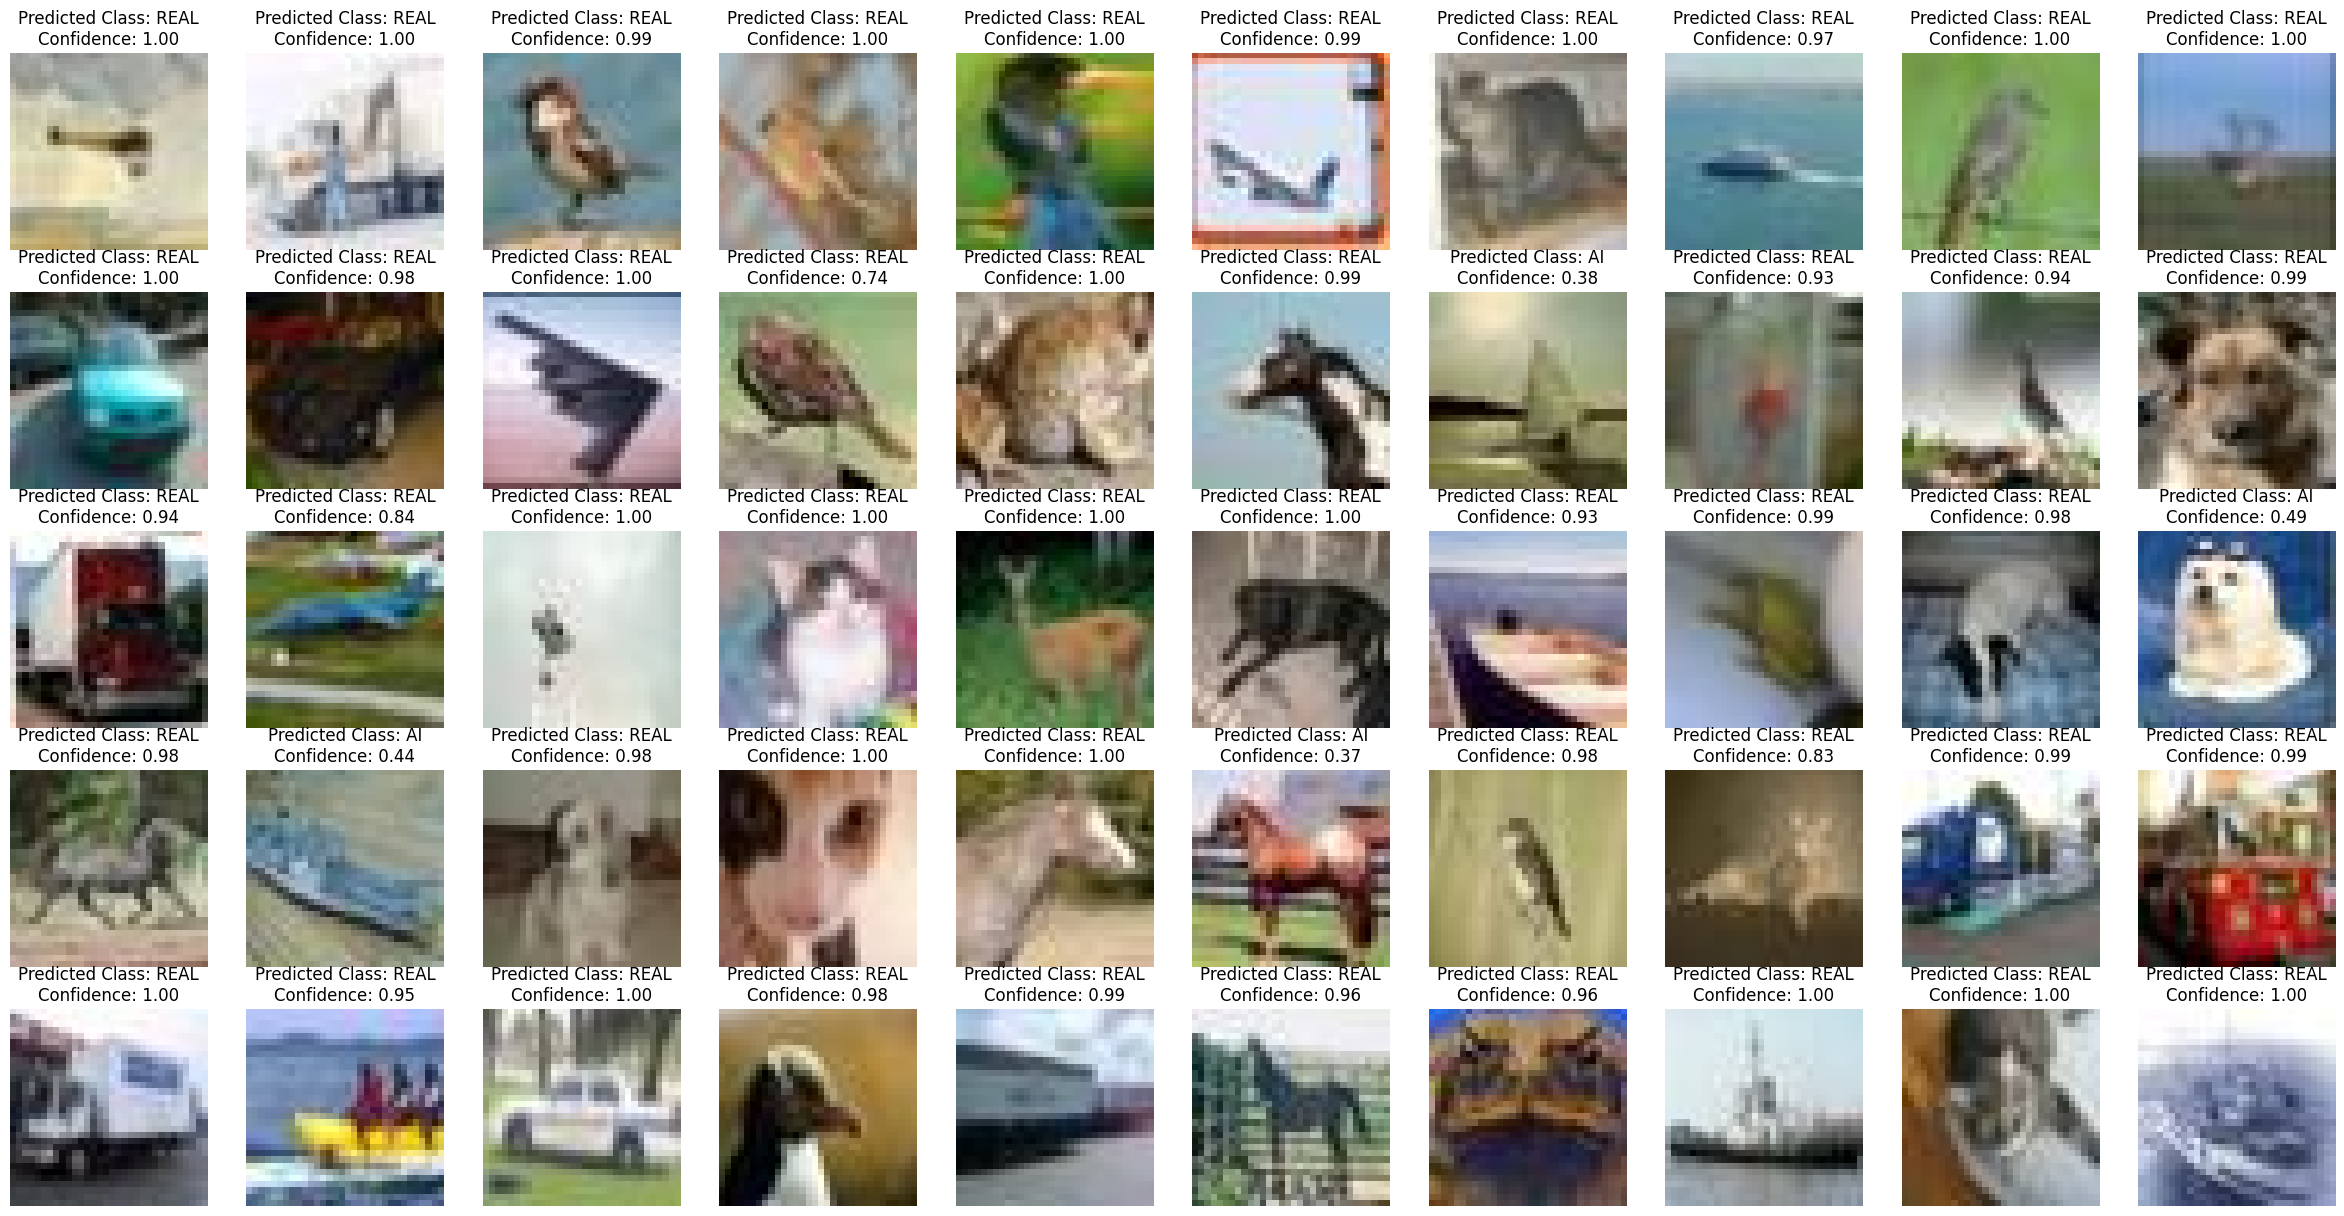

In [ ]:
# Load the trained model
model_path = os.path.join('ai_model', 'ai_imageclassifier.keras')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file '{model_path}' not found.")
ai_model = load_model(model_path)

# Define a function to preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = tf.image.resize(img, (32, 32))  # Resize to the input size expected by the model
    # Reshape to include color channels and batch dimension
    img_resized = tf.reshape(img_resized, [1, 32, 32, 3])
    return img_resized / 255.0

# Define the path to the test images
test_images_path = '/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/test'

# Collect all image paths
image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(test_images_path)
               for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]


# Display the first 50 images
num_images_to_display = 50
image_paths_to_display = image_paths[:num_images_to_display]
preprocessed_images = [preprocess_image(img_path) for img_path in image_paths_to_display]

# Stack the preprocessed images
input_images = np.stack(preprocessed_images)

# Preprocess and predict for each image individually
predictions = []
for img_path in image_paths_to_display:
    preprocessed_image = preprocess_image(img_path)
    prediction = ai_model.predict(preprocessed_image)
    predictions.append(prediction)

# Stack the predictions
predictions = np.vstack(predictions)

# Convert predictions to class labels
predicted_classes = ['REAL' if pred > 0.5 else 'AI' for pred in predictions] # Assuming 0.5 threshold

# Display the results
plt.figure(figsize=(30, 15))
for i, (img_path, pred_class, confidence) in enumerate(zip(image_paths_to_display, predicted_classes, predictions)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.title(f'Predicted Class: {pred_class}\nConfidence: {confidence[0]:.2f}')
    plt.axis('off')
plt.show()

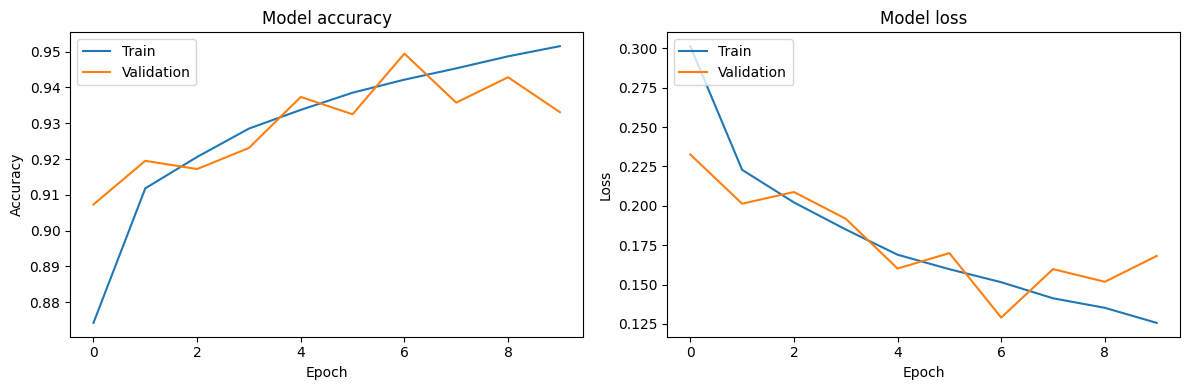

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_ai.history['accuracy'])
plt.plot(history_ai.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_ai.history['loss'])
plt.plot(history_ai.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

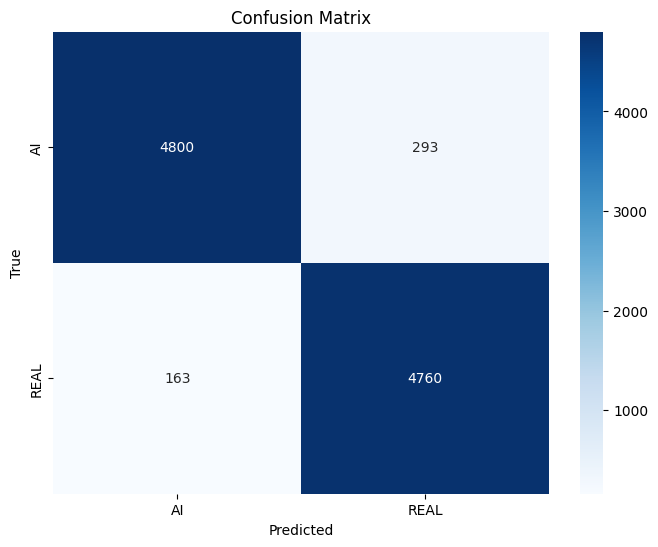

Classification Report:
               precision    recall  f1-score   support

          AI       0.97      0.94      0.95      5093
        REAL       0.94      0.97      0.95      4923

    accuracy                           0.95     10016
   macro avg       0.95      0.95      0.95     10016
weighted avg       0.95      0.95      0.95     10016



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(ai_model.predict(X).flatten())

y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:\n", class_report)

In [ ]:
df = pd.read_csv('/content/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

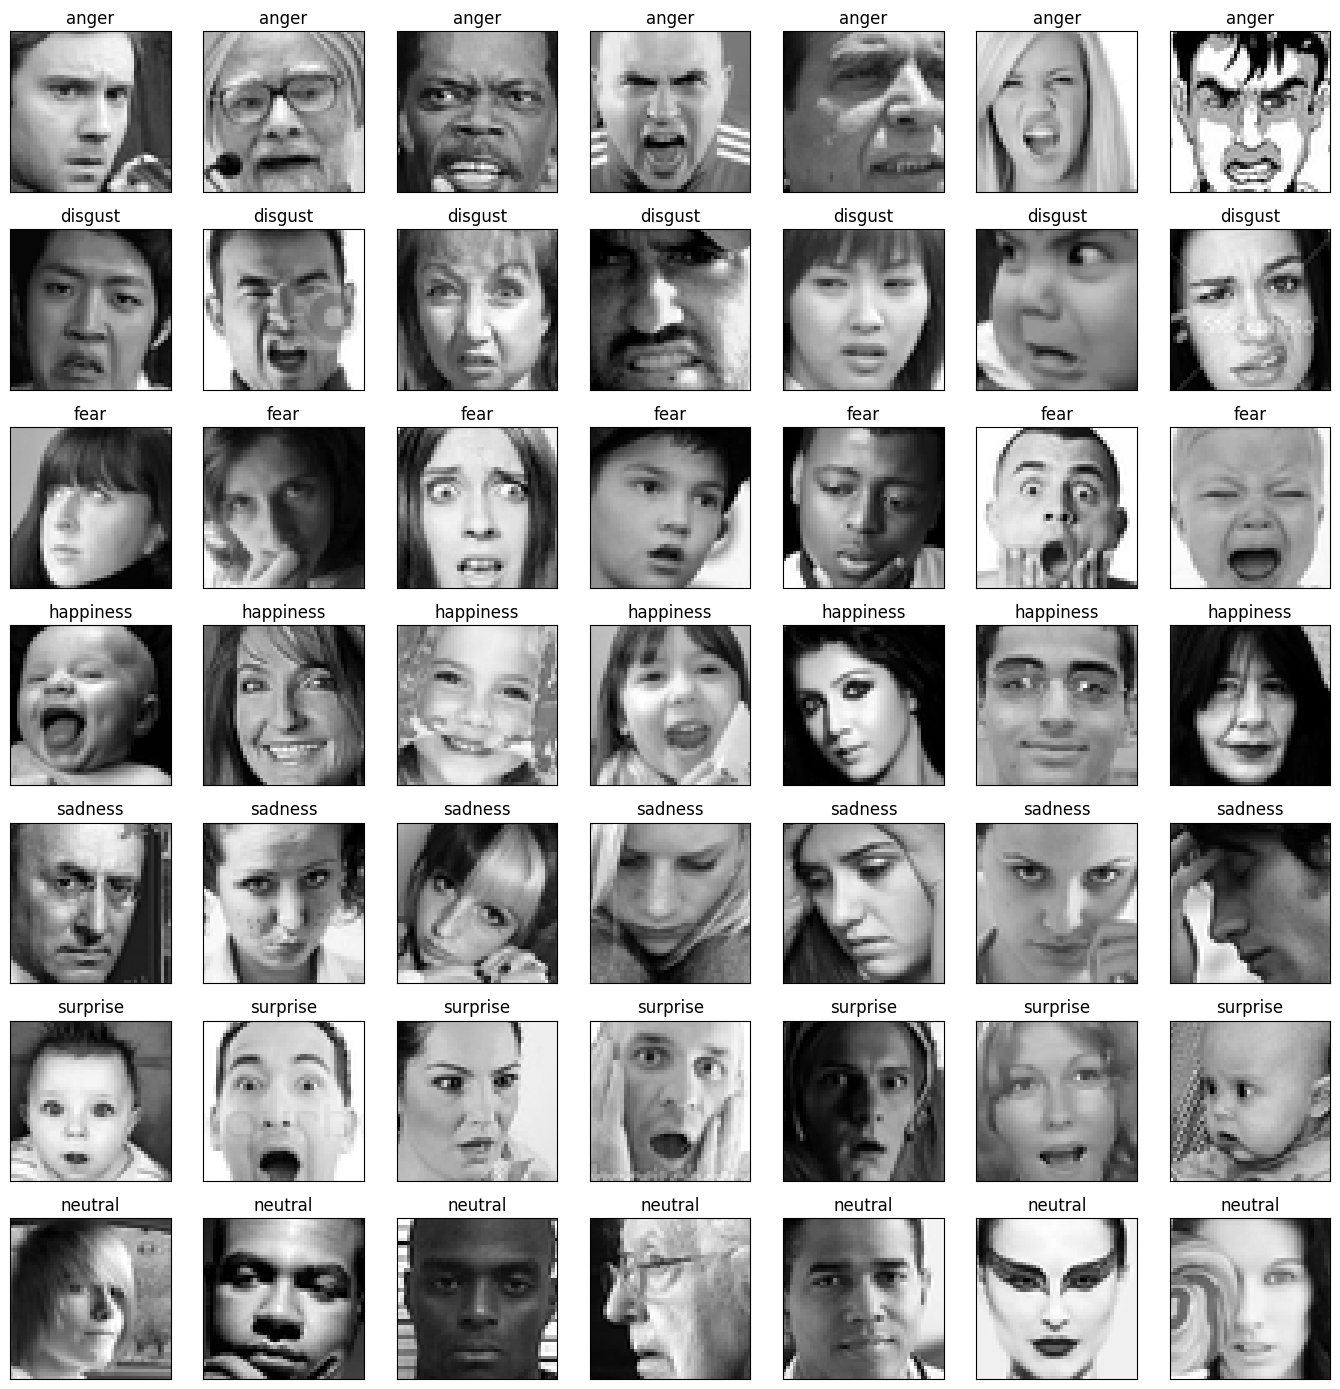

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [ ]:
import numpy as np

def reshape_pixels(pixels):
    try:
        pixel_array = np.array(pixels.split(' '), dtype=np.float32)
        # Check if the number of elements is correct for reshaping
        if pixel_array.size == 48 * 48:
            return pixel_array.reshape(48, 48)
        else:
            # Create a default array filled with 0 and fill with existing data
            default_array = np.zeros((48, 48), dtype=np.float32)
            default_array.ravel()[:pixel_array.size] = pixel_array
            print(f"Warning: Pixel data with {pixel_array.size} elements filled with 0 to shape (48, 48).")
            return default_array
    except ValueError:
        print(f"Warning: Invalid pixel data format. Filling with 0 to shape (48, 48).")
        return np.zeros((48, 48), dtype=np.float32)

# Apply the function to the 'pixels' column
img_array = df.pixels.apply(reshape_pixels)

# Stack the reshaped images into a single array
img_array = np.stack(img_array.values, axis=0)

In [ ]:
img_array.shape

(35887, 48, 48)

In [ ]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


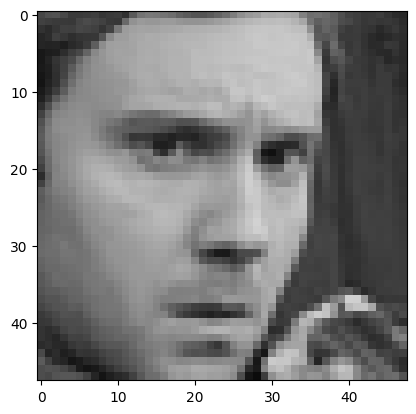

In [ ]:
plt.imshow(img_features[0].astype(np.uint8));

In [ ]:

import tensorflow as tf

le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = tf.keras.utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
del df
del img_features
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [ ]:

head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 20,027,975 (76.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001,
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

# batch size of 32 performs the best.
batch_size = 32
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001,
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) // batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 105s 92ms/step - accuracy: 0.3214 - loss: 1.6677 - val_accuracy: 0.5052 - val_loss: 1.2772 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.4688 - loss: 1.2141

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4688 - loss: 1.2141 - val_accuracy: 0.5130 - val_loss: 1.2779 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 70s 69ms/step - accuracy: 0.5050 - loss: 1.2912 - val_accuracy: 0.5545 - val_loss: 1.1501 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5312 - loss: 1.4421 - val_accuracy: 0.5508 - val_loss: 1.1564 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - accuracy: 0.5470 - loss: 1.1836 - val_accuracy: 0.5717 - val_loss: 1.1242 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.3890 - val_accuracy: 0.5754 - val_loss: 1.1122 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 66s 65ms/step - accuracy: 0.5818 - loss: 1.1094 - val_accuracy: 0.6024 - val_loss: 1.0578 - learning_rate: 1.0000e-04
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - a

In [ ]:

os.makedirs('emotion_model', exist_ok=True)

model.save("emotion_model/emotion_model.h5")

loaded_model = tf.keras.models.load_model("emotion_model/emotion_model.h5")


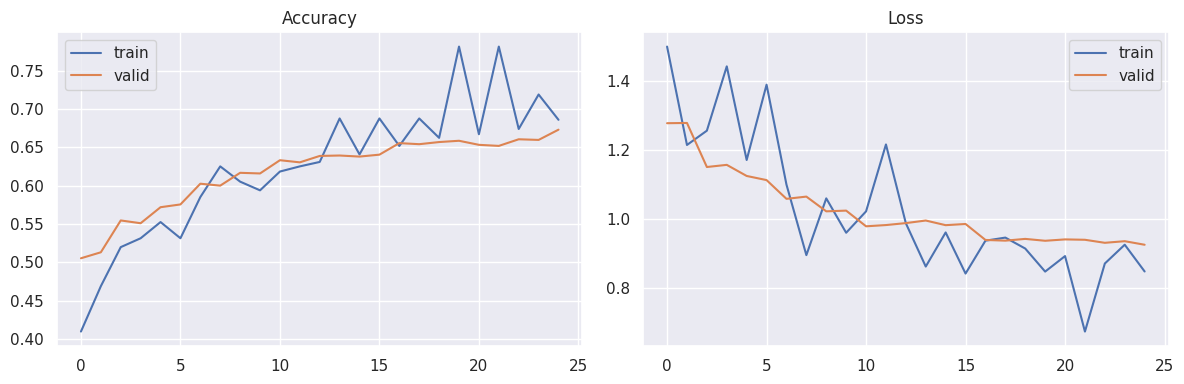

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


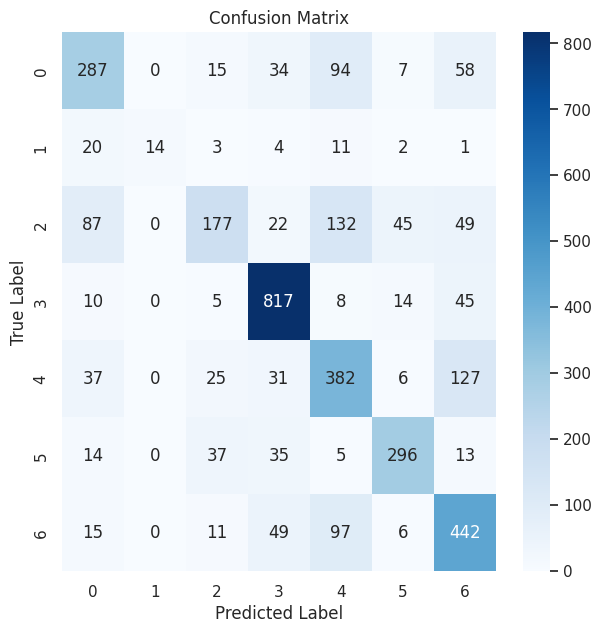

total wrong validation predictions: 1174


              precision    recall  f1-score   support

           0       0.61      0.58      0.59       495
           1       1.00      0.25      0.41        55
           2       0.65      0.35      0.45       512
           3       0.82      0.91      0.86       899
           4       0.52      0.63      0.57       608
           5       0.79      0.74      0.76       400
           6       0.60      0.71      0.65       620

    accuracy                           0.67      3589
   macro avg       0.71      0.60      0.61      3589
weighted avg       0.68      0.67      0.66      3589



In [ ]:
!pip install scipy matplotlib seaborn scikit-learn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from scipy.interpolate import interp1d

# Assuming you have your model predictions in yhat_valid and true labels in y_valid
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, yhat_valid)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_dcnn.png")
plt.show()

print(f'total wrong validation predictions: {np.sum(y_true != yhat_valid)}\n\n')
print(classification_report(y_true, yhat_valid))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


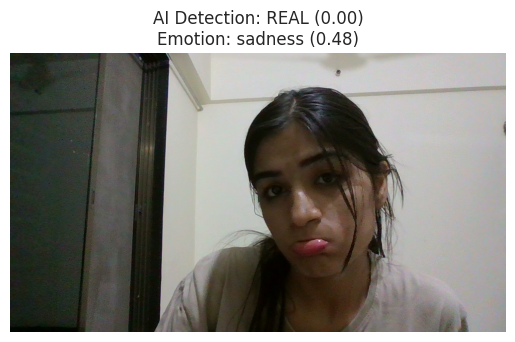

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load both the trained models
ai_model_path = 'ai_model/ai_imageclassifier.keras'
emotion_model_path = 'emotion_model/emotion_model.h5'

ai_model = tf.keras.models.load_model(ai_model_path)
emotion_model = tf.keras.models.load_model(emotion_model_path)

# Emotion label mapping
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Function to preprocess the image for AI vs REAL prediction (32x32 input size)
def preprocess_for_ai_detection(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = tf.image.resize(img, (32, 32))  # Resize to match input size for AI model
    img_resized = np.expand_dims(img_resized / 255.0, axis=0)  # Scale and add batch dimension
    return img_resized

# Function to preprocess the image for emotion detection (48x48 grayscale input size)
def preprocess_for_emotion_detection(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Add a channel dimension to the grayscale image
    img_gray = np.expand_dims(img_gray, axis=-1)
    img_resized = tf.image.resize(img_gray, (48, 48))
    img_resized = np.stack([img_resized[:,:,0]] * 3, axis=-1) # Convert grayscale to 3 channels to fit VGG19 input
    img_resized = np.expand_dims(img_resized / 255.0, axis=0)  # Scale and add batch dimension
    return img_resized

# Prediction function
def predict_image(image_path):
    # Preprocess images for both models
    ai_input = preprocess_for_ai_detection(image_path)
    emotion_input = preprocess_for_emotion_detection(image_path)

    # AI vs REAL prediction
    ai_pred_prob = ai_model.predict(ai_input)
    ai_prediction = "AI" if ai_pred_prob > 0.5 else "REAL"
    ai_confidence = ai_pred_prob[0][0]

    # Emotion prediction
    emotion_pred_prob = emotion_model.predict(emotion_input)
    emotion_class = np.argmax(emotion_pred_prob)
    emotion_prediction = emotion_label_to_text[emotion_class]
    emotion_confidence = emotion_pred_prob[0][emotion_class]

    # Display the results
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"AI Detection: {ai_prediction} ({ai_confidence:.2f})\nEmotion: {emotion_prediction} ({emotion_confidence:.2f})")
    plt.show()

image_path = "/content/sad_rid.jpg"
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


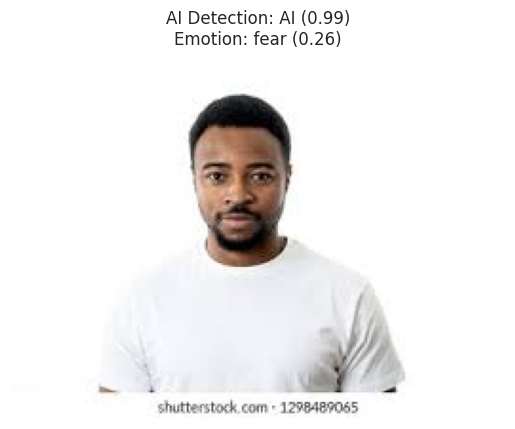

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ai_model_path = 'ai_model/ai_imageclassifier.keras'
emotion_model_path = 'emotion_model/emotion_model.h5'

ai_model = tf.keras.models.load_model(ai_model_path)
emotion_model = tf.keras.models.load_model(emotion_model_path)

emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

def preprocess_for_ai_detection(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = tf.image.resize(img, (32, 32))
    img_resized = np.expand_dims(img_resized / 255.0, axis=0)
    return img_resized

def preprocess_for_emotion_detection(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = np.expand_dims(img_gray, axis=-1)
    img_resized = tf.image.resize(img_gray, (48, 48))
    img_resized = np.stack([img_resized[:,:,0]] * 3, axis=-1)
    img_resized = np.expand_dims(img_resized / 255.0, axis=0)
    return img_resized


def predict_image(image_path):
    # Preprocess images for both models
    ai_input = preprocess_for_ai_detection(image_path)
    emotion_input = preprocess_for_emotion_detection(image_path)

    # AI vs REAL prediction
    ai_pred_prob = ai_model.predict(ai_input)
    ai_prediction = "AI" if ai_pred_prob > 0.5 else "REAL"
    ai_confidence = ai_pred_prob[0][0]

    # Emotion prediction
    emotion_pred_prob = emotion_model.predict(emotion_input)
    emotion_class = np.argmax(emotion_pred_prob)
    emotion_prediction = emotion_label_to_text[emotion_class]
    emotion_confidence = emotion_pred_prob[0][emotion_class]

    # Display the results
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"AI Detection: {ai_prediction} ({ai_confidence:.2f})\nEmotion: {emotion_prediction} ({emotion_confidence:.2f})")
    plt.show()

image_path = "/content/neutral.jpg"
predict_image(image_path)
